<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20TMS%20feature%20Shapley%20vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Install necessary packages (if not already installed in the environment) ---
# We'll use H2O for AutoML
!pip install h2o --quiet

# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import warnings
warnings.filterwarnings("ignore") # Suppress potential warnings

# --- 1. Initialize H2O ---
print("Initializing H2O...")
h2o.init()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 5.2 MB/s eta 0:00:00
Initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpha8lt6fg
  JVM stdout: /tmp/tmpha8lt6fg/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpha8lt6fg/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_teiz7e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.147 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [8]:
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_timeseries_clusters.csv'

raw_data = pd.read_csv(link_url, sep = ',')
raw_data = raw_data.drop('Unnamed: 0',axis=1)
raw_data.head(5)

,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DWT_Cluster,Inh_Thresh_DTW_Cluster
0,patient_ 1,178.163333,67.882676,1.257902,140.767500,27.082901,0.291345,0.0,0
1,patient_ 2,51.333667,30.594125,1.937557,73.485333,30.241820,0.849184,0.0,1
2,patient_ 3,189.062500,63.825718,1.729370,145.275000,35.421334,0.495146,0.0,2
3,patient_ 4,88.539167,29.056679,0.237006,66.661917,16.158868,0.504025,0.0,1
4,patient_ 5,59.761333,46.520112,1.369517,59.291833,28.441472,1.495100,0.0,1


In [9]:
df = raw_data

In [10]:
# --- 3. Data Preprocessing for H2O ---
# Identify columns to use for modeling (features and potential targets)
# Exclude 'patient_id' as it's an identifier
all_columns = df.columns.tolist()
feature_columns = [col for col in all_columns if col != 'patient_id']

print(f"\nAll columns: {all_columns}")
print(f"\nFeature columns identified: {feature_columns}")

# Handle missing values (H2O can handle some NA, but for consistency in target evaluation,
# let's drop rows with any missing values in potential target columns)
# It's often better to let H2O handle missing values internally for features during modeling.
# However, for evaluating target performance, clean targets are needed.
# Let's drop rows where ANY column has missing values for this analysis.
df_clean = df.dropna()
print(f"\nShape after dropping rows with missing values: {df_clean.shape}")

X_clean_df = df_clean[feature_columns].copy()
y_potential_df = df_clean[feature_columns] # All features are potential targets

# Convert the clean pandas DataFrame to an H2O Frame
h2o_df = h2o.H2OFrame(df_clean)
print("\nData successfully converted to H2O Frame.")


All columns: ['patient_id', 'Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DWT_Cluster', 'Inh_Thresh_DTW_Cluster']

Feature columns identified: ['Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DWT_Cluster', 'Inh_Thresh_DTW_Cluster']

Shape after dropping rows with missing values: (44, 9)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

Data successfully converted to H2O Frame.


In [11]:
# --- 4. Define a function to evaluate H2O AutoML performance for each potential target column ---
def find_best_target_h2o_automl(h2o_frame, feature_cols, potential_target_cols, max_runtime_secs=120):
    """
    Iterates through each column in potential_target_cols, treating it as a target,
    and uses H2O AutoML to build a model. The performance (e.g., R2 for regression,
    AUC/M logloss for classification) of the model is used as a proxy to determine
    the 'best' target column. Higher performance might indicate that the column
    is easier to predict from the other features, suggesting a strong underlying
    relationship or structure.
    """
    results = {}
    best_score = float('-inf') # We'll use a generic 'score', taking the primary metric
    best_column = None
    best_task = None
    best_leaderboard = None

    for col in potential_target_cols:
        print(f"\n--- Evaluating '{col}' as potential target ---")
        y = col
        X = [c for c in feature_cols if c != y] # Use all other features as predictors

        # Determine task type based on the target column's data type in the H2O frame
        h2o_type = h2o_frame.type(col)
        print(f"  H2O determined type for '{col}': {h2o_type}")

        # H2O usually infers 'enum' for categorical/string and 'int'/'real' for numeric.
        # For integer columns that might represent clusters (classification),
        # H2O might still treat them as regression. We might need to explicitly convert.
        # Let's assume H2O's inference is mostly correct for now, but check unique values.
        unique_vals_frame = h2o_frame[y].unique()
        unique_count = unique_vals_frame.nrows
        total_count = h2o_frame.nrows
        print(f"  Unique values in '{col}': {unique_count}")

        if h2o_type == 'enum' or unique_count < max(2, total_count * 0.05): # Treat as classification
             task = 'classification'
             # Ensure the target is treated as enum if it's numeric but categorical
             h2o_frame[y] = h2o_frame[y].asfactor()
        elif h2o_type in ['int', 'real']:
             task = 'regression'
        else:
            print(f"  Skipping '{col}' due to unsupported H2O type: {h2o_type}")
            continue

        print(f"  Determined task type: {task}")

        # Split the H2O frame
        train, test = h2o_frame.split_frame(ratios=[0.8], seed=42)

        # Initialize H2O AutoML
        aml = H2OAutoML(
            max_runtime_secs=max_runtime_secs, # Run for max 2 minutes per target
            seed=42,
            verbosity='info' # Can be 'info', 'warn', 'quiet' to manage output
        )

        # Fit the AutoML model
        print(f"  Fitting H2O AutoML for {task} on '{col}'...")
        aml.train(x=X, y=y, training_frame=train)

        # Check the leaderboard for the best model's performance
        lb = aml.leaderboard
        print(lb.head())

        if lb.nrows == 0:
            print(f"  No models were trained successfully for target '{col}'. Skipping.")
            continue

        # Get the primary metric for the best model
        # H2O AutoML leaderboard has standard column names.
        # For regression: 'r2', 'rmse', 'mae', 'deviance'
        # For classification: 'mean_per_class_error', 'logloss', 'AUC' (if binary), 'AUCpr'
        # We'll take the best model's R2 for regression or mean_per_class_error (minimize) or logloss (minimize) for classification.
        best_model_id = lb[0, 'model_id']
        print(f"  Best model for '{col}': {best_model_id}")

        if task == 'regression':
            # Look for R2 score (higher is better)
            if 'r2' in lb.columns:
                score_val = lb[0, 'r2']
                score_name = "R2"
                if score_val is not None:
                    score_val = float(score_val) # H2O returns H2OFloat, convert to Python float
                    score = score_val # Higher R2 is better
                else:
                     print(f"    R2 not found for best model of '{col}', using 0.")
                     score = 0.0
            else:
                # If R2 is not present (e.g., if all models failed to report it), use another metric like negative RMSE
                rmse_val = lb[0, 'rmse']
                if rmse_val is not None:
                    rmse_val = float(rmse_val)
                    score = -rmse_val # Negative RMSE, so higher (less negative) is better
                    score_name = "-RMSE"
                else:
                     print(f"    R2 and RMSE not found for best model of '{col}', using 0.")
                     score = 0.0
                     score_name = "Placeholder"

        elif task == 'classification':
             # Look for mean_per_class_error (lower is better) or logloss (lower is better)
             # We want a score where HIGHER is better, so we'll use negative error or inverse of logloss if needed.
             # logloss is usually lower for better models. We can use negative logloss.
             if 'logloss' in lb.columns and lb[0, 'logloss'] is not None:
                 logloss_val = float(lb[0, 'logloss'])
                 score = -logloss_val # Negative logloss, so higher (less negative) is better
                 score_name = "-LogLoss"
             elif 'mean_per_class_error' in lb.columns and lb[0, 'mean_per_class_error'] is not None:
                  mce_val = float(lb[0, 'mean_per_class_error'])
                  score = -mce_val # Negative mean per class error, so higher (less negative) is better
                  score_name = "-MeanPerClassError"
             elif 'auc' in lb.columns and lb[0, 'auc'] is not None: # For binary classification
                  auc_val = float(lb[0, 'auc'])
                  score = auc_val # AUC, higher is better
                  score_name = "AUC"
             else:
                 print(f"    No standard classification metric found for best model of '{col}', using 0.")
                 score = 0.0
                 score_name = "Placeholder"

        print(f"  Best {score_name} for '{col}': {score:.4f}")

        results[col] = {
            'score': score,
            'score_name': score_name,
            'task': task,
            'leaderboard': lb
        }

        # Update best column if current score is better
        # Note: This comparison works if score is consistently higher for better performance
        if score > best_score:
            best_score = score
            best_column = col
            best_task = task
            best_leaderboard = lb

    print("\n--- Summary of H2O AutoML Performance for Potential Targets ---")
    # Sort results by score (descending) for better readability
    sorted_results = sorted(results.items(), key=lambda item: item[1]['score'], reverse=True)
    for col, res in sorted_results:
        print(f"  {col:<25} | {res['score_name']:<15} | {res['score']:.4f} | Task: {res['task']}")
    print(f"\nBest target column based on H2O AutoML performance: '{best_column}' with {results[best_column]['score_name']}: {best_score:.4f} (Task: {best_task})")

    return best_column, best_score, best_task, results, best_leaderboard


# --- Run the H2O AutoML-based target identification ---
best_target_col, best_score, best_task, all_results, best_lb = find_best_target_h2o_automl(
    h2o_df, feature_columns, y_potential_df.columns, max_runtime_secs=120
)

# --- Print the leaderboard for the best target ---
print(f"\n--- Leaderboard for the Best Target ('{best_target_col}') ---")
print(best_lb)

# --- 5. Shutdown H2O ---
print("\nShutting down H2O...")
h2o.shutdown(prompt=False)

print("\nDone.")


--- Evaluating 'Avg_Resp_Left_Mean' as potential target ---
  H2O determined type for 'Avg_Resp_Left_Mean': real
  Unique values in 'Avg_Resp_Left_Mean': 43
  Determined task type: regression
  Fitting H2O AutoML for regression on 'Avg_Resp_Left_Mean'...
AutoML progress: |
15:08:21.593: Project: AutoML_1_20251207_150821
15:08:21.596: 5-fold cross-validation will be used.
15:08:21.597: Setting stopping tolerance adaptively based on the training frame: 0.05
15:08:21.597: Build control seed: 42
15:08:21.598: training frame: Frame key: AutoML_1_20251207_150821_training_py_3_sid_bdb0    cols: 9    rows: 38  chunks: 1    size: 3102  checksum: -6938311266809522650
15:08:21.598: validation frame: NULL
15:08:21.599: leaderboard frame: NULL
15:08:21.599: blending frame: NULL
15:08:21.600: response column: Avg_Resp_Left_Mean
15:08:21.600: fold column: null
15:08:21.600: weights column: null
15:08:21.633: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), gri

# Shapley values
Initialize H2O, load `df_clean` into an H2OFrame, retrieve the best model using `best_lb`, calculate Shapley values for the best model on the training data, and then visualize the feature importance using these Shapley values.

# Task
Install the SHAP library, re-initialize H2O, import SHAP, load the best H2O model identified previously, prepare the feature data for SHAP analysis, calculate SHAP values, and then generate and display two SHAP force plots to visualize individual predictions. Finally, shut down the H2O cluster.

## Install SHAP Library

### Subtask:
Install the `shap` Python library, which is required for SHAP value calculations and visualizations.


**Reasoning**:
The subtask requires installing the `shap` library, so a code block with the `!pip install shap` command is necessary.



In [16]:
pip install shap

## Initialize H2O and Import SHAP

### Subtask:
Re-initialize H2O (as it was shut down in the previous cell) and correctly import the `shap` library (using `import shap`) to ensure all necessary tools are available for model loading and explanation.


**Reasoning**:
Re-initialize H2O and import the shap library as requested by the subtask.



In [17]:
import h2o
import shap

print("Re-initializing H2O...")
h2o.init()
print("SHAP library imported.")

Re-initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,15 mins 04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_kniuq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.147 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


SHAP library imported.


In [22]:
# Re-create H2OFrame for the current session
h2o_df_current_session = h2o.H2OFrame(df_clean)

# Get the best target column and task from the previous analysis
y_col = best_target_col
x_cols = [col for col in feature_columns if col != y_col]
task = best_task

# Ensure the target column is correctly typed for the task in the current H2OFrame
if task == 'classification':
    h2o_df_current_session[y_col] = h2o_df_current_session[y_col].asfactor()

print(f"Re-running AutoML for target '{y_col}' (Task: {task}) to obtain a valid model in the current H2O session...")

# Re-run AutoML for the best target column in the current session
aml_current_session = H2OAutoML(
    max_runtime_secs=60, # Reduced runtime to quickly get a model for SHAP
    seed=42,
    verbosity='warn'
)
aml_current_session.train(x=x_cols, y=y_col, training_frame=h2o_df_current_session)

# Get the new best model from the current session's AutoML leaderboard
current_best_lb = aml_current_session.leaderboard
model_id = current_best_lb[0, 'model_id']
best_model = h2o.get_model(model_id)

# Convert feature data to H2OFrame for SHAP, excluding the target column
h2o_feature_frame = h2o.H2OFrame(df_clean[[col for col in feature_columns if col != y_col]])

print(f"Loaded best model from current session: {best_model.model_id}")
print("Feature data converted to H2OFrame.")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Re-running AutoML for target 'Avg_Resp_DWT_Cluster' (Task: regression) to obtain a valid model in the current H2O session...
AutoML progress: |██
15:43:59.211: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 44.0.

█████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loaded best model from current session: GBM_grid_1_AutoML_1_20251207_154354_model_2
Feature data converted to H2OFrame.


**Reasoning**:
Now that the H2O model and feature data are ready, I will calculate SHAP values using `shap.TreeExplainer` for the first two data points from the `h2o_feature_frame`. This will provide the necessary values to create individual force plots as requested by the subtask.



In [24]:
contributions = best_model.predict_contributions(h2o_feature_frame)

# Convert the H2OFrame contributions to a pandas DataFrame
contributions_df = contributions.as_data_frame()

# Extract SHAP values (all columns except 'BiasTerm')
shap_values_individual = contributions_df.drop(columns=['BiasTerm']).values

# The 'BiasTerm' represents the expected value (base value)
# We take the first value as expected_value is typically constant for a given model or dataset
expected_value = contributions_df['BiasTerm'].iloc[0]

print(f"SHAP values calculated using H2O's predict_contributions.")
print(f"Calculated SHAP values for {len(shap_values_individual)} instances.")
print(f"Expected (base) value: {expected_value}")

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
SHAP values calculated using H2O's predict_contributions.
Calculated SHAP values for 44 instances.
Expected (base) value: 0.1654074788093567


**Reasoning**:
With SHAP values and the expected value now correctly calculated, I will generate two individual SHAP force plots for the first two data instances. This visualization will illustrate how each feature contributes to the model's prediction for these specific instances.



Generating SHAP force plot for instance 1...


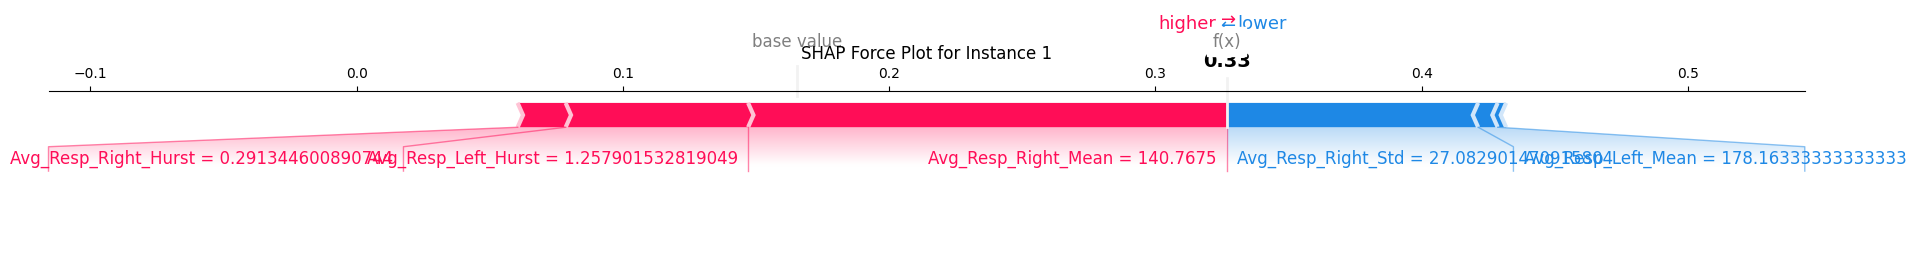

Generating SHAP force plot for instance 2...


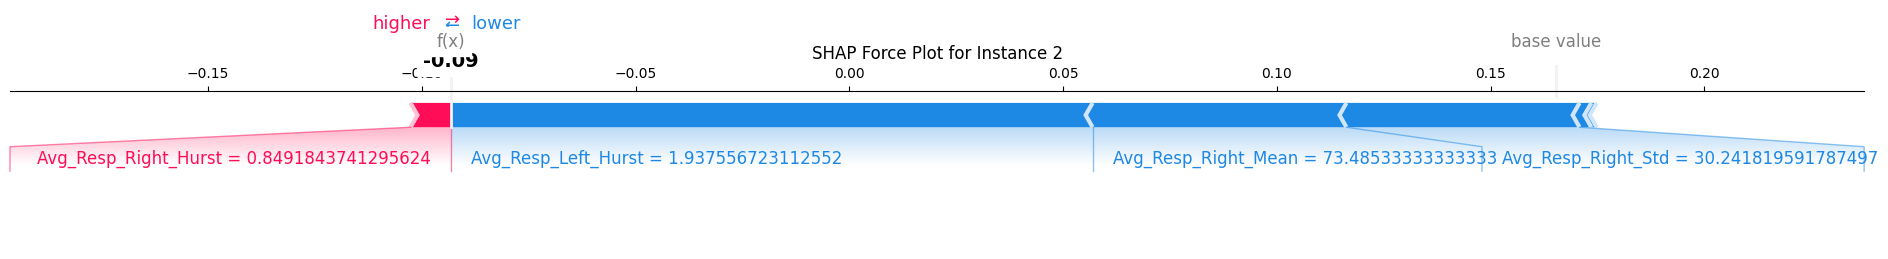

In [25]:
import matplotlib.pyplot as plt

# Get the feature names directly from the h2o_feature_frame for consistent labeling
feature_names = h2o_feature_frame.col_names

# Select the first two instances for plotting
instance_1_shap_values = shap_values_individual[0]
instance_1_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[0]

instance_2_shap_values = shap_values_individual[1]
instance_2_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[1]

print("Generating SHAP force plot for instance 1...")
shap.force_plot(expected_value, instance_1_shap_values, instance_1_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 1")
plt.tight_layout()
plt.show()

print("Generating SHAP force plot for instance 2...")
shap.force_plot(expected_value, instance_2_shap_values, instance_2_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 2")
plt.tight_layout()
plt.show()